In [19]:
# %% Imports
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt  # Matplotlib import
%matplotlib inline
import matplotlib.colors as mcolors
import random
import os
from scipy.interpolate import splprep, splev
from mmcv.utils import Config
import mmcv
import torch
# ... rest of your imports ...

In [20]:
# %% --- Configuration ---
# Path to your dataset root
DATA_ROOT = '/work3/s203557/data/ade20k-dataset/versions/2/ADEChallengeData2016'
# Path to image and annotation directories (using validation set for testing)
IMG_DIR = os.path.join(DATA_ROOT, 'images', 'validation')
ANN_DIR = os.path.join(DATA_ROOT, 'annotations', 'validation')


In [21]:
# Parameters for the generator
MAX_BOXES_VIS = 20
MIN_AREA_VIS = 100
MAX_AREA_RATIO_VIS = 0.3 # Example: Max 30% of image area

# Drawing parameters
BBOX_THICKNESS = 2

In [22]:
# --- Fixed BBox Generator ---
class GenerateClassUnionBoundingBoxMask:
    """ Fixed version with force_class and debug prints """
    def __init__(self, target_classes, ignore_label=255, closing_kernel_size=None):
        if not isinstance(target_classes, (list, set, tuple)): raise TypeError("target_classes must be list/set/tuple")
        self.target_classes = set(target_classes)
        self.ignore_label = ignore_label
        self.closing_kernel_size = closing_kernel_size
        if closing_kernel_size is not None:
             if not isinstance(closing_kernel_size, int) or closing_kernel_size <= 1:
                  print(f"Warning: Invalid closing_kernel_size ({closing_kernel_size}). Closing disabled.")
                  self.closing_kernel_size = None
        if not self.target_classes: print("Warning: BBox Generator initialized with empty target_classes.")

    def __call__(self, results, force_class=None): # Added force_class argument
        if 'gt_semantic_seg' not in results: raise KeyError("'gt_semantic_seg' not found.")
        seg_map = results['gt_semantic_seg']
        if isinstance(seg_map, torch.Tensor): seg_map = seg_map.cpu().numpy()
        if seg_map.ndim == 3 and seg_map.shape[0] == 1: seg_map = seg_map.squeeze(0)
        elif seg_map.ndim != 2: raise ValueError(f"Input seg_map shape error: {seg_map.shape}")

        height, width = seg_map.shape
        union_mask = np.zeros((height, width), dtype=np.uint8)
        component_bboxes = []
        # Initialize results keys robustly
        results['selected_prompt_class'] = None
        results['gt_bbox_union_mask'] = torch.from_numpy(union_mask).float().unsqueeze(0)
        results['gt_component_bboxes'] = component_bboxes

        present_labels = np.unique(seg_map)
        available_target_classes = [lbl for lbl in present_labels if lbl in self.target_classes and lbl != self.ignore_label]

        selected_class = None
        if force_class is not None:
            if force_class in available_target_classes:
                selected_class = force_class
                # print(f"[DEBUG BBox] Using forced class: {selected_class}")
            else:
                print(f"[DEBUG BBox] Warning: Forced class {force_class} not in available {available_target_classes}. Skipping.")
                # Return with empty outputs if forced class is invalid
                return results # Already initialized with empty mask/list
        elif available_target_classes:
            selected_class = random.choice(available_target_classes)
            # print(f"[DEBUG BBox] Randomly selected class: {selected_class}")

        if selected_class is None:
            # print("[DEBUG BBox] No target class could be selected.")
            return results # Return with empty outputs

        results['selected_prompt_class'] = selected_class

        class_mask = (seg_map == selected_class).astype(np.uint8)
        processed_mask = class_mask
        if self.closing_kernel_size:
            # print(f"[DEBUG BBox] Applying closing k={self.closing_kernel_size}")
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (self.closing_kernel_size, self.closing_kernel_size))
            processed_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel)

        num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(processed_mask, connectivity=8)
        # print(f"[DEBUG BBox] Found {num_labels - 1} component(s) for class {selected_class} AFTER processing.")

        for i in range(1, num_labels):
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            x1, y1 = max(0, x), max(0, y)
            x2, y2 = min(x + w, width), min(y + h, height)
            if x1 < x2 and y1 < y2:
                union_mask[y1:y2, x1:x2] = 1
                component_bboxes.append((x1, y1, x2, y2))

        # print(f"[DEBUG BBox] Collected {len(component_bboxes)} boxes.")
        print(f"[DEBUG BBox] Final BBox mask sum for class {selected_class}: {union_mask.sum()}") # DEBUG SUM
        results['gt_bbox_union_mask'] = torch.from_numpy(union_mask).float().unsqueeze(0)
        results['gt_component_bboxes'] = component_bboxes
        return results


# --- Fixed Dot Generator ---
class GenerateClassCentroidDotMask:
    """ Fixed version with force_class and debug prints """
    def __init__(self, target_classes, ignore_label=255, closing_kernel_size=None):
        if not isinstance(target_classes, (list, set, tuple)): raise TypeError("target_classes must be list/set/tuple")
        self.target_classes = set(target_classes)
        self.ignore_label = ignore_label
        self.closing_kernel_size = closing_kernel_size
        if closing_kernel_size is not None:
             if not isinstance(closing_kernel_size, int) or closing_kernel_size <= 1:
                  print(f"Warning: Invalid closing_kernel_size ({closing_kernel_size}). Closing disabled.")
                  self.closing_kernel_size = None
        if not self.target_classes: print("Warning: Dot Generator initialized with empty target_classes.")

    def __call__(self, results, force_class=None): # Added force_class argument
        if 'gt_semantic_seg' not in results: raise KeyError("'gt_semantic_seg' not found.")
        seg_map = results['gt_semantic_seg']
        if isinstance(seg_map, torch.Tensor): seg_map = seg_map.cpu().numpy()
        if seg_map.ndim == 3 and seg_map.shape[0] == 1: seg_map = seg_map.squeeze(0)
        elif seg_map.ndim != 2: raise ValueError(f"Input seg_map shape error: {seg_map.shape}")

        height, width = seg_map.shape
        dot_mask = np.zeros((height, width), dtype=np.uint8)
        component_centroids = []
        # Initialize results keys robustly
        # Note: We rely on bbox generator setting selected_prompt_class if run sequentially without force_class
        # It's better practice to reset it here if not forcing, but force_class avoids this issue.
        # results['selected_prompt_class'] = None # Uncomment if running independently
        results['gt_centroid_dot_mask'] = torch.from_numpy(dot_mask).float().unsqueeze(0)
        results['gt_component_centroids'] = component_centroids

        present_labels = np.unique(seg_map)
        available_target_classes = [lbl for lbl in present_labels if lbl in self.target_classes and lbl != self.ignore_label]

        selected_class = None
        if force_class is not None:
            if force_class in available_target_classes:
                selected_class = force_class
                # print(f"[DEBUG Dot] Using forced class: {selected_class}")
            else:
                print(f"[DEBUG Dot] Warning: Forced class {force_class} not in available {available_target_classes}. Skipping.")
                return results # Return with empty outputs
        elif available_target_classes:
            selected_class = random.choice(available_target_classes)
            # print(f"[DEBUG Dot] Randomly selected class: {selected_class}")

        if selected_class is None:
            # print("[DEBUG Dot] No target class could be selected.")
            return results # Return with empty outputs

        # Ensure selected_prompt_class reflects the class actually used
        results['selected_prompt_class'] = selected_class

        class_mask = (seg_map == selected_class).astype(np.uint8)
        processed_mask = class_mask
        if self.closing_kernel_size:
            # print(f"[DEBUG Dot] Applying closing k={self.closing_kernel_size}")
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (self.closing_kernel_size, self.closing_kernel_size))
            processed_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel)

        num_labels, labels_im, stats, centroids_data = cv2.connectedComponentsWithStats(processed_mask, connectivity=8)
        # print(f"[DEBUG Dot] Found {num_labels - 1} component(s) for class {selected_class} AFTER processing.")

        for i in range(1, num_labels):
            cx_f, cy_f = centroids_data[i]
            cx, cy = int(round(cx_f)), int(round(cy_f))
            if 0 <= cx < width and 0 <= cy < height:
                dot_mask[cy, cx] = 1
                component_centroids.append((cx, cy))

        # print(f"[DEBUG Dot] Collected {len(component_centroids)} centroids.")
        print(f"[DEBUG Dot] Final Dot mask sum for class {selected_class}: {dot_mask.sum()}") # DEBUG SUM
        results['gt_centroid_dot_mask'] = torch.from_numpy(dot_mask).float().unsqueeze(0)
        results['gt_component_centroids'] = component_centroids
        return results


# --- Fixed Scribble Generator ---
class GenerateClassScribbleMask:
    """ Fixed version with force_class and debug prints """
    def __init__(self, target_classes, ignore_label=255, closing_kernel_size=None,
                 min_component_area=20, min_scribble_points=3, max_scribble_points=8,
                 points_per_1k_area=1.0, num_interpolated_points=50, scribble_thickness=2):

        if not isinstance(target_classes, (list, set, tuple)): raise TypeError("target_classes must be list/set/tuple")
        self.target_classes = set(target_classes)
        self.ignore_label = ignore_label
        self.closing_kernel_size = closing_kernel_size
        if closing_kernel_size is not None:
            if not isinstance(closing_kernel_size, int) or closing_kernel_size <= 1:
                print(f"Warning: Invalid closing_kernel_size ({closing_kernel_size}). Closing disabled.")
                self.closing_kernel_size = None
        self.min_component_area = max(1, min_component_area)
        self.min_scribble_points = max(2, min_scribble_points)
        self.max_scribble_points = max(self.min_scribble_points, max_scribble_points)
        self.points_per_1k_area = max(0, points_per_1k_area)
        self.num_interpolated_points = max(2, num_interpolated_points)
        self.scribble_thickness = max(1, scribble_thickness)
        if not self.target_classes: print("Warning: Scribble Generator initialized with empty target_classes.")

    def __call__(self, results, force_class=None): # Added force_class argument
        if 'gt_semantic_seg' not in results: raise KeyError("'gt_semantic_seg' not found.")
        seg_map = results['gt_semantic_seg']
        if isinstance(seg_map, torch.Tensor): seg_map = seg_map.cpu().numpy()
        if seg_map.ndim == 3 and seg_map.shape[0] == 1: seg_map = seg_map.squeeze(0)
        elif seg_map.ndim != 2: raise ValueError(f"Input seg_map shape error: {seg_map.shape}")

        height, width = seg_map.shape
        scribble_mask = np.zeros((height, width), dtype=np.uint8)
        component_scribble_points = []
        # Initialize results keys robustly
        # results['selected_prompt_class'] = None # See comment in Dot Generator
        results['gt_scribble_mask'] = torch.from_numpy(scribble_mask).float().unsqueeze(0)
        results['gt_component_scribble_points'] = component_scribble_points

        present_labels = np.unique(seg_map)
        available_target_classes = [lbl for lbl in present_labels if lbl in self.target_classes and lbl != self.ignore_label]

        selected_class = None
        if force_class is not None:
            if force_class in available_target_classes:
                selected_class = force_class
                # print(f"[DEBUG Scribble] Using forced class: {selected_class}")
            else:
                print(f"[DEBUG Scribble] Warning: Forced class {force_class} not in available {available_target_classes}. Skipping.")
                return results # Return with empty outputs
        elif available_target_classes:
            selected_class = random.choice(available_target_classes)
            # print(f"[DEBUG Scribble] Randomly selected class: {selected_class}")

        if selected_class is None:
            # print("[DEBUG Scribble] No target class could be selected.")
            return results # Return with empty outputs

        results['selected_prompt_class'] = selected_class

        class_mask = (seg_map == selected_class).astype(np.uint8)
        processed_mask = class_mask
        if self.closing_kernel_size:
            # print(f"[DEBUG Scribble] Applying closing k={self.closing_kernel_size}")
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (self.closing_kernel_size, self.closing_kernel_size))
            processed_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel)

        num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(processed_mask, connectivity=8)
        # print(f"[DEBUG Scribble] Found {num_labels - 1} component(s) for class {selected_class} AFTER processing.")

        for i in range(1, num_labels):
            component_area = stats[i, cv2.CC_STAT_AREA]
            if component_area < self.min_component_area: continue

            points_based_on_area = int(round(self.points_per_1k_area * (component_area / 1000.0)))
            num_points = np.clip(self.min_scribble_points + points_based_on_area, self.min_scribble_points, self.max_scribble_points)

            rows, cols = np.where(labels_im == i)
            if len(rows) < num_points: num_points = len(rows)
            if num_points < 2: continue

            sampled_indices = random.sample(range(len(rows)), num_points)
            sampled_points = [(cols[idx], rows[idx]) for idx in sampled_indices]
            sampled_points_np = np.array(sampled_points)
            component_scribble_points.append(sampled_points) # Store list of tuples

            try:
                if num_points >= 3:
                    x_coords, y_coords = sampled_points_np[:, 0], sampled_points_np[:, 1]
                    tck, u = splprep([x_coords, y_coords], s=0, k=min(3, num_points - 1))
                    u_fine = np.linspace(0, 1, self.num_interpolated_points)
                    x_fine, y_fine = splev(u_fine, tck)
                    points_to_draw = np.vstack((x_fine, y_fine)).T.round().astype(np.int32)
                    cv2.polylines(scribble_mask, [points_to_draw], isClosed=False, color=1, thickness=self.scribble_thickness, lineType=cv2.LINE_AA)
                elif num_points == 2:
                    pt1 = tuple(sampled_points_np[0].astype(int))
                    pt2 = tuple(sampled_points_np[1].astype(int))
                    cv2.line(scribble_mask, pt1, pt2, color=1, thickness=self.scribble_thickness, lineType=cv2.LINE_AA)
            except Exception as e:
                 print(f"[DEBUG Scribble] Error generating spline/line for component {i}: {e}. Sampled points: {sampled_points}")

        # print(f"[DEBUG Scribble] Collected points for {len(component_scribble_points)} scribbles.")
        print(f"[DEBUG Scribble] Final Scribble mask sum for class {selected_class}: {scribble_mask.sum()}") # DEBUG SUM
        results['gt_scribble_mask'] = torch.from_numpy(scribble_mask).float().unsqueeze(0)
        results['gt_component_scribble_points'] = component_scribble_points
        return results

In [23]:
# --- Define Colors ---
# Use a mix of colors for potentially many boxes per class
distinct_colors_hex = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values()) # More colors
random.shuffle(distinct_colors_hex) # Shuffle to get variety

# Ensure enough colors, repeating if necessary
if len(distinct_colors_hex) < MAX_BOXES_VIS:
     distinct_colors_hex = (distinct_colors_hex * (MAX_BOXES_VIS // len(distinct_colors_hex) + 1))

# Limit to MAX_BOXES_VIS and get BGR format
distinct_colors_hex = distinct_colors_hex[:MAX_BOXES_VIS]

def hex_to_bgr(hex_color):
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return rgb[::-1] # Convert RGB to BGR

COLOR_PALETTE_BGR = [hex_to_bgr(c) for c in distinct_colors_hex]
if not COLOR_PALETTE_BGR: # Fallback if hex conversion failed
    COLOR_PALETTE_BGR = [(0, 255, 0)] * MAX_BOXES_VIS # Default to green

In [24]:
def create_ade20k_distinguished_cmap(num_classes=150, ignore_label=255, ignore_color='#000000'):
    """
    Creates a more distinct colormap for ADE20k (150 classes) + ignore label.

    Args:
        num_classes (int): Number of valid semantic classes (default: 150 for ADE20k).
        ignore_label (int): The integer value used for the ignore label (default: 255).
        ignore_color (str): Hex color code for the ignore label (default: black).

    Returns:
        matplotlib.colors.ListedColormap: The custom colormap.
        matplotlib.colors.Normalize: Normalization instance for the colormap.
    """
    # Base distinct colormaps from matplotlib
    # Using tab20b, tab20c, Set3 which provide different sets of colors
    colors_tab20b = plt.cm.tab20b(np.linspace(0, 1, 20))
    colors_tab20c = plt.cm.tab20c(np.linspace(0, 1, 20))
    colors_set3 = plt.cm.Set3(np.linspace(0, 1, 12))
    # Combine and repeat to get enough colors for num_classes
    base_colors = np.vstack((colors_tab20b, colors_tab20c, colors_set3))

    # Repeat the base colors until we have at least num_classes
    num_repeats = (num_classes // len(base_colors)) + 1
    dist_colors_rgba = np.vstack([base_colors] * num_repeats)[:num_classes] # Take only the first num_classes

    # Create the full palette list (size 256 for indices 0-255)
    # Initialize with the ignore color (converted to RGBA float 0-1)
    ignore_rgba = mcolors.to_rgba(ignore_color)
    full_palette_rgba = np.tile(ignore_rgba, (256, 1)) # Fill with ignore color first

    # Assign the distinct colors to the valid class indices (0 to num_classes-1)
    full_palette_rgba[0:num_classes, :] = dist_colors_rgba

    # Create the ListedColormap
    cmap = mcolors.ListedColormap(full_palette_rgba)

    # Create normalization object to map data values 0-255 to the cmap indices
    norm = mcolors.Normalize(vmin=0, vmax=255)

    return cmap, norm

In [25]:
def load_ade20k_sample(img_dir, ann_dir, filename_base):
    """Loads image (BGR) and annotation (adjusted labels) for ADE20K."""
    img_path = os.path.join(img_dir, filename_base + '.jpg')
    ann_path = os.path.join(ann_dir, filename_base + '.png')

    if not os.path.exists(img_path):
        print(f"Image file not found: {img_path}")
        return None
    if not os.path.exists(ann_path):
        print(f"Annotation file not found: {ann_path}")
        return None

    # Load image as BGR numpy array
    img = mmcv.imread(img_path, channel_order='bgr')
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None

    # Load annotation as is (usually uint8)
    gt_semantic_seg = mmcv.imread(ann_path, flag='unchanged', backend='pillow')
    if gt_semantic_seg is None:
        print(f"Failed to load annotation: {ann_path}")
        return None

    # Apply the reduce_zero_label logic: Map 0->ignore, 1->0, 2->1, ... N->N-1
    # This assumes the generator expects 0-indexed classes and ignore_label=255
    ignore_label = 255
    mask = gt_semantic_seg == 0 # Find background pixels (original label 0)
    gt_semantic_seg = gt_semantic_seg - 1 # Shift other labels 1..N -> 0..N-1
    gt_semantic_seg[mask] = ignore_label # Assign ignore_label to original background

    results = {
        'filename': filename_base + '.jpg',
        'img': img, # BGR numpy array
        'gt_semantic_seg': gt_semantic_seg, # Numpy array, labels 0..N-1, ignore=255
        'seg_fields': ['gt_semantic_seg'],
        'img_shape': img.shape[:2],
        'ori_shape': img.shape[:2],
    }
    return results

In [26]:
def visualize_component_bboxes(sample_result, thickness=2):
    """
    Visualizes image, GT seg (with distinct colors), and component bounding boxes (red).

    Args:
        sample_result (dict): Dictionary containing 'img', 'gt_semantic_seg',
                              'gt_component_bboxes', and optionally 'selected_prompt_class'.
        thickness (int): Thickness of the bounding box lines.
    """
    print(f"\n--- Visualizing Component BBoxes (All Red) ---")
    img_bgr = sample_result.get('img')
    gt_seg = sample_result.get('gt_semantic_seg') # Should have labels 0-149 and ignore=255
    component_bboxes = sample_result.get('gt_component_bboxes')
    selected_class = sample_result.get('selected_prompt_class')
    filename = sample_result.get('filename', 'N/A')

    # --- (Validation remains the same) ---
    if img_bgr is None: print("Error: Image ('img') not found."); return
    if gt_seg is None: print("Error: Ground truth segmentation ('gt_semantic_seg') not found."); return
    if component_bboxes is None: print("Key 'gt_component_bboxes' not found or is None.")
    elif not isinstance(component_bboxes, list):
        print(f"Error: 'gt_component_bboxes' should be a list."); component_bboxes = []

    num_boxes = len(component_bboxes) if component_bboxes else 0
    print(f"Found {num_boxes} component bounding boxes for class {selected_class}.")

    img_with_boxes = img_bgr.copy()
    RED_BGR = (0, 0, 255)

    # --- (Drawing boxes remains the same) ---
    if component_bboxes:
        for (x1, y1, x2, y2) in component_bboxes:
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), RED_BGR, thickness)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    title_suffix = f" (Class {selected_class}, {num_boxes} Boxes)" if selected_class is not None else f" ({num_boxes} Boxes)"
    fig.suptitle(f"Filename: {filename}{title_suffix}", fontsize=14)

    def bgr_to_rgb(img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[0].imshow(bgr_to_rgb(img_bgr))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # --- Create and use the distinguished colormap for GT Segmentation --- ## MODIFIED PART ##
    ade_cmap, ade_norm = create_ade20k_distinguished_cmap(num_classes=150, ignore_label=255)
    axes[1].imshow(gt_seg, cmap=ade_cmap, norm=ade_norm)
    axes[1].set_title("GT Segmentation (Distinct Colors)") # Updated title
    axes[1].axis('off')
    # -------------------------------------------------------------------- ## END MODIFIED PART ##

    axes[2].imshow(bgr_to_rgb(img_with_boxes))
    axes[2].set_title("Image + Component BBoxes (Red)")
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

[DEBUG BBox] Final BBox mask sum for class 41: 587
Found image 'ADE_val_00001256.jpg' with target class 41.

--- Visualizing Component BBoxes (All Red) ---
Found 3 component bounding boxes for class 41.


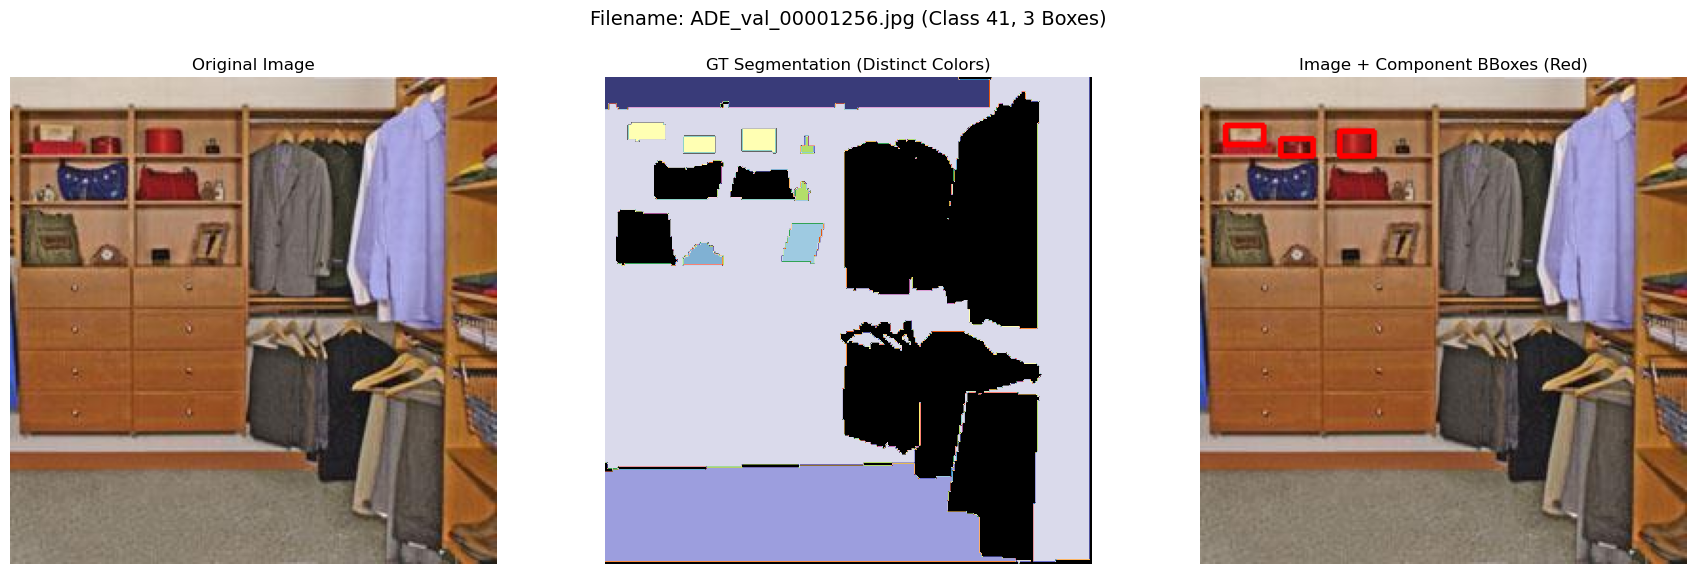

In [27]:
try:
    # --- Choose Target Classes (Use 0-based indexing!) ---
    low_iou_classes_zero_indexed = [12, 16, 17, 20, 25, 29, 32, 41, 42, 54, 58, 59, 63, 70, 72, 84, 95, 116, 129, 4] # Example IDs (0 to 149)
    if not low_iou_classes_zero_indexed:
         print("Warning: low_iou_classes_zero_indexed list is empty!")

    # --- Instantiate Generator ---
    union_bbox_generator = GenerateClassUnionBoundingBoxMask(
        target_classes=low_iou_classes_zero_indexed,
        ignore_label=255,
        closing_kernel_size=6,
    )

    img_files_basenames = [os.path.splitext(f)[0] for f in os.listdir(IMG_DIR) if f.endswith('.jpg')]
    if not img_files_basenames:
        raise FileNotFoundError(f"No JPG files found in {IMG_DIR}")

    max_attempts = 20
    selected_class = None
    updated_results = None

    for attempt in range(max_attempts):
        random_basename = random.choice(img_files_basenames)
        results_dict = load_ade20k_sample(IMG_DIR, ANN_DIR, random_basename)
        if results_dict is None: continue

        updated_results = union_bbox_generator(results_dict)
        selected_class = updated_results.get('selected_prompt_class')

        if selected_class is not None:
            print(f"Found image '{random_basename}.jpg' with target class {selected_class}.")
            break

    if selected_class is None and 'attempt' in locals() and attempt == max_attempts - 1:
        print(f"Warning: Could not find any target classes {low_iou_classes_zero_indexed} in {max_attempts} random samples.")

    # --- Plotting ---
    if selected_class is not None and updated_results:
        # Call visualize_component_bboxes WITHOUT the color palette argument
        visualize_component_bboxes(
            sample_result=updated_results,
            thickness=BBOX_THICKNESS # Use the defined constant
        )
    elif updated_results: # Plot even if no target class found
         print("No target class selected/found, visualizing image and GT mask only.")
         updated_results['gt_component_bboxes'] = []
         updated_results['selected_prompt_class'] = None
         visualize_component_bboxes(
            sample_result=updated_results,
            thickness=BBOX_THICKNESS
         )
    else:
        print("Could not generate plot as no suitable image was loaded or processed.")

except FileNotFoundError as e:
    print(f"Error: {e}. Check paths.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

    import traceback
    traceback.print_exc()

In [29]:
def visualize_component_scribbles(sample_result, scribble_color_bgr=(255, 0, 255), thickness=2): # Magenta scribbles
    """
    Visualizes image, GT seg, and simulated scribbles.
    """
    print(f"\n--- Visualizing Component Scribbles ---")
    img_bgr = sample_result.get('img')
    gt_seg = sample_result.get('gt_semantic_seg')
    # List of arrays, where each array holds [(x,y),...] points for one scribble
    component_scribble_points_list = sample_result.get('gt_component_scribble_points')
    selected_class = sample_result.get('selected_prompt_class')
    filename = sample_result.get('filename', 'N/A')
    scribble_mask_tensor = sample_result.get('gt_scribble_mask')

    # --- (Validation) ---
    if img_bgr is None: print("Error: Image not found."); return
    if gt_seg is None: print("Error: GT Seg not found."); return
    if component_scribble_points_list is None: print("Key 'gt_component_scribble_points' not found.")
    elif not isinstance(component_scribble_points_list, list): print("Error: Scribble points not a list."); component_scribble_points_list = []

    num_scribbles = len(component_scribble_points_list) if component_scribble_points_list else 0
    print(f"Found data for {num_scribbles} scribbles for class {selected_class}.")

    img_with_scribbles = img_bgr.copy()

    # Re-draw scribbles on the image for visualization using the stored points
    if component_scribble_points_list:
        for point_array in component_scribble_points_list:
            if len(point_array) >= 3: # Re-interpolate and draw (smoother than just connecting points)
                 try:
                    x_coords = point_array[:, 0]
                    y_coords = point_array[:, 1]
                    tck, u = splprep([x_coords, y_coords], s=0, k=min(3, len(point_array) - 1))
                    u_fine = np.linspace(0, 1, 50) # Use fixed number for visualization consistency
                    x_fine, y_fine = splev(u_fine, tck)
                    points_to_draw = np.vstack((x_fine, y_fine)).T.round().astype(np.int32)
                    cv2.polylines(img_with_scribbles, [points_to_draw], isClosed=False, color=scribble_color_bgr, thickness=thickness, lineType=cv2.LINE_AA)
                 except Exception: # Fallback to lines if spline fails during viz
                    pts = point_array.reshape((-1, 1, 2)).astype(np.int32)
                    cv2.polylines(img_with_scribbles, [pts], isClosed=False, color=scribble_color_bgr, thickness=thickness, lineType=cv2.LINE_AA)
            elif len(point_array) == 2: # Draw line
                 pt1 = tuple(point_array[0].astype(int))
                 pt2 = tuple(point_array[1].astype(int))
                 cv2.line(img_with_scribbles, pt1, pt2, color=scribble_color_bgr, thickness=thickness, lineType=cv2.LINE_AA)


    # --- Plotting ---
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    title_suffix = f" (Class {selected_class}, {num_scribbles} Scribbles)" if selected_class is not None else f" ({num_scribbles} Scribbles)"
    fig.suptitle(f"Filename: {filename}{title_suffix}", fontsize=14)

    def bgr_to_rgb(img): return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[0].imshow(bgr_to_rgb(img_bgr)); axes[0].set_title("Original Image"); axes[0].axis('off')

    ade_cmap, ade_norm = create_ade20k_distinguished_cmap() # Assumes exists
    axes[1].imshow(gt_seg, cmap=ade_cmap, norm=ade_norm); axes[1].set_title("GT Segmentation"); axes[1].axis('off')

    axes[2].imshow(bgr_to_rgb(img_with_scribbles)); axes[2].set_title("Image + Scribbles"); axes[2].axis('off')

    if scribble_mask_tensor is not None:
        axes[3].imshow(scribble_mask_tensor.squeeze(0).cpu().numpy(), cmap='gray')
        axes[3].set_title("Generated Scribble Mask Tensor"); axes[3].axis('off')
    else:
        axes[3].text(0.5, 0.5, 'Scribble Mask\nNot Generated', ha='center', va='center', transform=axes[3].transAxes); axes[3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [78]:
# Parameters for generators
low_iou_classes_zero_indexed = [i for i in range(1,151)] # Example
ignore_label = 255
KERNEL_SIZE_FOR_CLOSING = 7 # Example morphological closing kernel size

# --- Instantiate ALL Generators ---
bbox_generator = GenerateClassUnionBoundingBoxMask(
    target_classes=low_iou_classes_zero_indexed,
    ignore_label=ignore_label,
    closing_kernel_size=KERNEL_SIZE_FOR_CLOSING
)
dot_generator = GenerateClassCentroidDotMask(
    target_classes=low_iou_classes_zero_indexed,
    ignore_label=ignore_label,
    closing_kernel_size=3
)
scribble_generator = GenerateClassScribbleMask(
    target_classes=low_iou_classes_zero_indexed,
    ignore_label=ignore_label,
    closing_kernel_size=KERNEL_SIZE_FOR_CLOSING,
    min_component_area=20,
    min_scribble_points=3,
    max_scribble_points=10, # Increased max points slightly
    points_per_1k_area=1.5,
    scribble_thickness=2
)


In [79]:
# --- Fixed Processing Function ---
def process_sample_all_prompts(img_dir, ann_dir, basename, target_classes, ignore_label_value):
    """Loads a sample and runs box, dot, and scribble generators FOR THE SAME CLASS."""
    results = load_ade20k_sample(img_dir, ann_dir, basename) # Assumes load_ade20k_sample uses ignore_label_value
    if results is None: return None

    seg_map = results['gt_semantic_seg']
    height, width = seg_map.shape if seg_map is not None else (None, None)

    # Initialize empty outputs FIRST for robustness
    results['selected_prompt_class_unified'] = None
    results['gt_bbox_union_mask'] = torch.zeros((1, height, width), dtype=torch.float32) if height else None
    results['gt_centroid_dot_mask'] = torch.zeros((1, height, width), dtype=torch.float32) if height else None
    results['gt_scribble_mask'] = torch.zeros((1, height, width), dtype=torch.float32) if height else None
    results['gt_component_bboxes'] = []
    results['gt_component_centroids'] = []
    results['gt_component_scribble_points'] = []


    present_labels = np.unique(seg_map)
    available_target_classes = [
        label for label in present_labels
        if label in target_classes and label != ignore_label_value # Use passed ignore_label
    ]

    if not available_target_classes:
        print(f"Sample {basename}: No target classes {target_classes} found in available labels {present_labels}. Skipping prompt generation.")
        return results # Return results with initialized empty prompts

    # Select ONE class for ALL generators
    selected_class_for_sample = random.choice(available_target_classes)
    print(f"Sample {basename}: Selected class {selected_class_for_sample} for all prompts.")
    results['selected_prompt_class_unified'] = selected_class_for_sample # Store for plotting title

    # Run generators, passing the forced class
    # Assumes bbox_generator, dot_generator, scribble_generator are globally defined and instantiated
    print(f"  Running BBox Gen (forced class {selected_class_for_sample})...")
    results = bbox_generator(results, force_class=selected_class_for_sample)
    print(f"  Running Dot Gen (forced class {selected_class_for_sample})...")
    results = dot_generator(results, force_class=selected_class_for_sample)
    print(f"  Running Scribble Gen (forced class {selected_class_for_sample})...")
    results = scribble_generator(results, force_class=selected_class_for_sample)

    # Final check for mask sums (can be commented out after debugging)
    print("  Finished running all generators. Final check on results:")
    bbox_mask = results.get('gt_bbox_union_mask')
    dot_mask = results.get('gt_centroid_dot_mask')
    scribble_mask = results.get('gt_scribble_mask')
    print(f"  BBox mask sum: {bbox_mask.sum().item() if bbox_mask is not None else 'N/A'}")
    print(f"  Dot mask sum: {dot_mask.sum().item() if dot_mask is not None else 'N/A'}")
    print(f"  Scribble mask sum: {scribble_mask.sum().item() if scribble_mask is not None else 'N/A'}")

    return results

In [91]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import matplotlib.colors as mcolors
import os

# --- Make sure create_ade20k_distinguished_cmap is defined somewhere above ---

def plot_prompt_grid_flipped(results_list,
                             class_names=None, # <-- Add class_names argument
                             prompt_color_bgr=(0, 0, 255),
                             highlight_color_rgb=(1.0, 0.0, 0.0),
                             alpha=0.6,
                             dot_radius=4,
                             save_path=None):
    """
    Plots a Nx5 grid (max 3 rows). Rotated Class Name/ID on left. Larger Text.
    Highlights selected class in RED on GT Seg. Saves SVG if path provided.

    Args:
        results_list (list): A list of processed results dictionaries (up to 3).
        class_names (list, optional): List mapping 0-indexed class IDs to names.
        prompt_color_bgr (tuple): BGR color for overlays and dots.
        highlight_color_rgb (tuple): RGB float color (0-1) for GT highlight.
        alpha (float): Transparency for box/scribble overlays.
        dot_radius (int): Radius for drawing centroid dots.
        save_path (str, optional): Path to save the plot as an SVG file.
    """
    num_samples = min(len(results_list), 3)
    print(f"\n--- Plotting FLIPPED grid for {num_samples} samples (Rotated Labels, Larger Text) ---")
    if num_samples == 0: print("No samples provided."); return

    # Adjust figsize slightly if needed for larger text/labels
    fig_width = 21
    fig_height_per_sample = 3.8 # Slightly increased height for larger text
    fig, axes = plt.subplots(num_samples, 5, figsize=(fig_width, fig_height_per_sample * num_samples))
    print(f"Created subplots grid with shape: ({num_samples}, 5)")
    if num_samples == 1: axes = axes[np.newaxis, :]

    try: base_ade_cmap, base_ade_norm = create_ade20k_distinguished_cmap()
    except NameError: print("Warning: create_ade20k_distinguished_cmap missing."); base_ade_cmap, base_ade_norm = 'viridis', None

    # --- Helper Functions (keep as before) ---
    def bgr_to_rgb(img):
        if img is None: return None
        try: return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception as e: print(f"Error converting BGR->RGB: {e}"); return None

    def create_mask_overlay(img_bgr, mask_tensor, color_bgr, alpha, prompt_type):
        # (Keep the robust version)
        if img_bgr is None: return None;
        if mask_tensor is None: return img_bgr;
        if not isinstance(mask_tensor, torch.Tensor): return img_bgr
        try:
            mask_np=mask_tensor.squeeze().cpu().numpy().astype(np.uint8)
            if mask_np.ndim!=2 or mask_np.shape!=img_bgr.shape[:2]: return img_bgr
            if mask_np.sum()==0: return img_bgr
            overlay=np.zeros_like(img_bgr,dtype=np.uint8); overlay[mask_np==1]=color_bgr
            beta=1.0-alpha; img_uint8=img_bgr.astype(np.uint8) if img_bgr.dtype!=np.uint8 else img_bgr
            return cv2.addWeighted(overlay,alpha,img_uint8,beta,0)
        except Exception as e: print(f"Overlay err {prompt_type}:{e}"); return img_bgr

    # --- Set Column Titles (Larger Font) ---
    column_titles = ["Original Image", "GT Segmentation", "Box Mask Overlay", "Centroid Dots", "Scribble Mask Overlay"]
    for col_idx, title in enumerate(column_titles):
         axes[0, col_idx].set_title(title, fontsize=14, pad=10) # Increased fontsize

    # --- Loop through Samples (Rows) ---
    for sample_idx in range(num_samples):
        sample_result = results_list[sample_idx]
        img_bgr = sample_result.get('img'); gt_seg = sample_result.get('gt_semantic_seg')
        filename = sample_result.get('filename', f'S{sample_idx+1}')
        selected_class = sample_result.get('selected_prompt_class_unified', None)

        # --- MODIFIED: Set Rotated Row Label with Class Name/ID (Larger Font) ---
        row_label = "Unknown Class"
        if selected_class is not None:
             if class_names and 0 <= selected_class < len(class_names):
                 row_label = class_names[selected_class] # Use name if available
             else:
                 row_label = f"Class ID: {selected_class}" # Fallback to ID
        elif selected_class is None and 'selected_prompt_class' in sample_result: # Check original key too
             # Fallback if unified key is missing but original exists
             original_class = sample_result.get('selected_prompt_class')
             if original_class is not None:
                 row_label = f"Class ID: {original_class}"


        ax_label = axes[sample_idx, 0] # Get axes for the first column
        ax_label.set_ylabel(row_label,
                            rotation=90,         # Rotate 90 degrees
                            size='large',        # Increase font size
                            labelpad=25,         # Adjust distance from plot edge
                            va='center',       # Align vertically to center
                            ha='right')        # Align horizontally
        # ---------------------------------------------------------------------

        if img_bgr is None or gt_seg is None: continue

        # --- Plot columns 0-4 (logic remains the same, only axes access changes) ---
        # Col 0: Original
        ax = axes[sample_idx, 0]; img_rgb = bgr_to_rgb(img_bgr)
        if img_rgb is not None: ax.imshow(img_rgb); ax.axis('off')

        # Col 1: GT Seg (with Highlight)
        ax = axes[sample_idx, 1]
        try:
            current_gt_seg = gt_seg
            if isinstance(current_gt_seg, torch.Tensor): current_gt_seg = current_gt_seg.cpu().numpy()
            if current_gt_seg.ndim == 3: current_gt_seg = current_gt_seg.squeeze()
            if current_gt_seg.ndim == 2:
                current_cmap = base_ade_cmap
                if selected_class is not None and base_ade_cmap is not None and hasattr(base_ade_cmap, 'colors') and 0 <= selected_class < len(base_ade_cmap.colors):
                     try:
                        colors_list = list(base_ade_cmap.colors); colors_list[selected_class] = highlight_color_rgb
                        current_cmap = mcolors.ListedColormap(colors_list)
                     except Exception: pass
                ax.imshow(current_gt_seg, cmap=current_cmap, norm=base_ade_norm)
            else: ax.text(0.5, 0.5, 'GT Err', ha='center', va='center', transform=ax.transAxes)
        except Exception: ax.text(0.5, 0.5, 'GT Err', ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

        # Col 2: Boxes
        ax = axes[sample_idx, 2]; box_mask_tensor = sample_result.get('gt_bbox_union_mask')
        img_overlay = create_mask_overlay(img_bgr, box_mask_tensor, prompt_color_bgr, alpha, "Box")
        img_rgb = bgr_to_rgb(img_overlay);
        if img_rgb is not None: ax.imshow(img_rgb); ax.axis('off')

        # Col 3: Dots
        ax = axes[sample_idx, 3]; centroids = sample_result.get('gt_component_centroids', [])
        img_dots = img_bgr.copy()
        if centroids:
            for (cx, cy) in centroids: cv2.circle(img_dots, (cx, cy), radius=dot_radius, color=prompt_color_bgr, thickness=-1)
        img_rgb = bgr_to_rgb(img_dots);
        if img_rgb is not None: ax.imshow(img_rgb); ax.axis('off')

        # Col 4: Scribbles
        ax = axes[sample_idx, 4]; scribble_mask_tensor = sample_result.get('gt_scribble_mask')
        img_overlay = create_mask_overlay(img_bgr, scribble_mask_tensor, prompt_color_bgr, alpha, "Scribble")
        img_rgb = bgr_to_rgb(img_overlay);
        if img_rgb is not None: ax.imshow(img_rgb); ax.axis('off')


    # --- Finalize Plot ---
    # --- ADJUSTED: Increase left margin significantly for rotated labels ---
    plt.subplots_adjust(left=0.25, right=0.98, top=0.90, bottom=0.02, wspace=0.05, hspace=0.1) # Reduced hspace, increased left, reduced top slightly
    # -----------------------------------------------------------------------

    print("\nPlotting completed.")
    if save_path:
        try:
            print(f"Saving plot to: {save_path}")
            fig.savefig(save_path, format='svg', bbox_inches='tight', pad_inches=0.1) # Slightly more pad
            print("Plot saved successfully as SVG.")
        except Exception as e: print(f"Error saving plot: {e}")

    print("Calling plt.show()...")
    plt.show()
    print("plt.show() executed.")
    # plt.close(fig) # Optional


Attempt 1: Processing sample ADE_val_00000354...
Sample ADE_val_00000354: Selected class 41 for all prompts.
  Running BBox Gen (forced class 41)...
[DEBUG BBox] Final BBox mask sum for class 41: 4565
  Running Dot Gen (forced class 41)...
[DEBUG Dot] Final Dot mask sum for class 41: 1
  Running Scribble Gen (forced class 41)...
[DEBUG Scribble] Final Scribble mask sum for class 41: 696
  Finished running all generators. Final check on results:
  BBox mask sum: 4565.0
  Dot mask sum: 1.0
  Scribble mask sum: 696.0
Added sample ADE_val_00000354. Total samples: 1

Attempt 2: Processing sample ADE_val_00000203...
Sample ADE_val_00000203: Selected class 1 for all prompts.
  Running BBox Gen (forced class 1)...
[DEBUG BBox] Final BBox mask sum for class 1: 65536
  Running Dot Gen (forced class 1)...
[DEBUG Dot] Final Dot mask sum for class 1: 1
  Running Scribble Gen (forced class 1)...
[DEBUG Scribble] Final Scribble mask sum for class 1: 4366
  Finished running all generators. Final chec

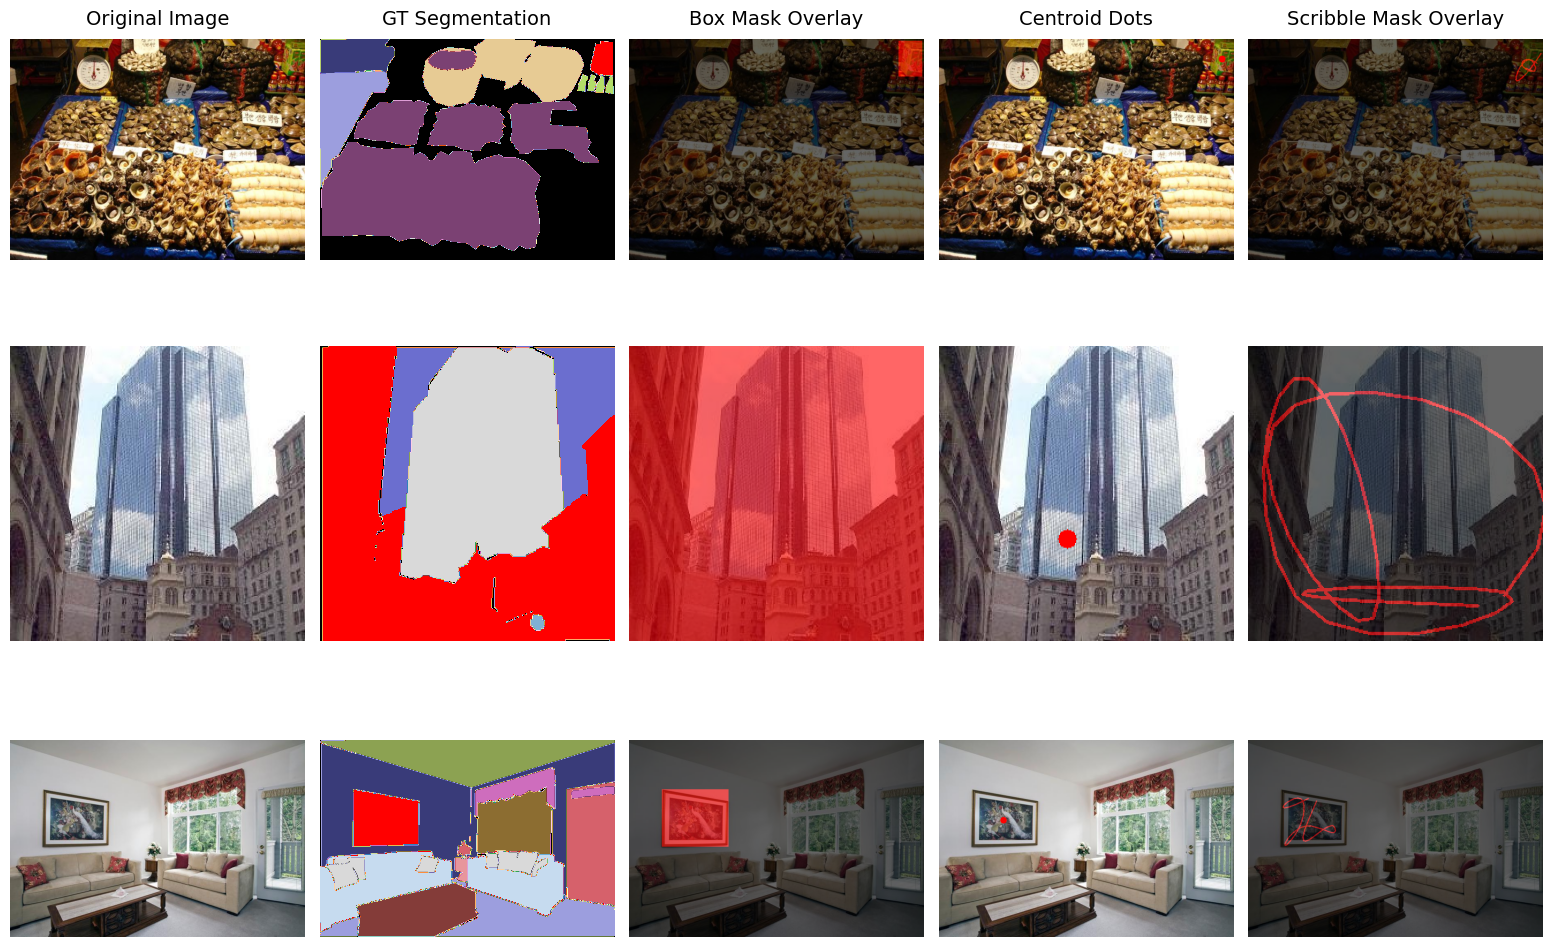

plt.show() executed.


In [94]:
num_samples_to_plot = 3  # <-- CHANGE THIS TO 3
processed_results_list = []
max_total_attempts = 50 # <<< --- DEFINE max_total_attempts HERE ---

try:
    img_files_basenames = [os.path.splitext(f)[0] for f in os.listdir(IMG_DIR) if f.endswith('.jpg')]
    if not img_files_basenames: raise FileNotFoundError(f"No JPG files found in {IMG_DIR}")

    attempts = 0 # Initialize attempts
    # Now max_total_attempts is defined before the loop uses it
    while len(processed_results_list) < num_samples_to_plot and attempts < max_total_attempts:
        attempts += 1
        random_basename = random.choice(img_files_basenames)
        print(f"\nAttempt {attempts}: Processing sample {random_basename}...")

        processed_sample = process_sample_all_prompts(IMG_DIR, ANN_DIR, random_basename,
                                                        set(low_iou_classes_zero_indexed),
                                                        ignore_label_value=ignore_label)

        if processed_sample:
            processed_results_list.append(processed_sample)
            print(f"Added sample {random_basename}. Total samples: {len(processed_results_list)}")
        else: print(f"Skipping {random_basename}.")

    if len(processed_results_list) == 0: print(f"\nWarning: No samples processed after {attempts} attempts.")

    # --- Call the NEW Flipped Grid Plotting Function ---
    if processed_results_list:
        print(f"\nPlotting FLIPPED grid for {len(processed_results_list)} samples...")
        plot_prompt_grid_flipped( # <-- Make sure this function is defined above
            results_list=processed_results_list,
            prompt_color_bgr=(0, 0, 255), # Red BGR
            alpha=0.6,
            dot_radius=8
        )
    else: print("\nNo samples were successfully processed to plot.")

except FileNotFoundError as e: print(f"Error: {e}. Check paths.")
except Exception as e: print(f"An unexpected error occurred: {e}"); import traceback; traceback.print_exc()

In [95]:
if processed_results_list:
    print(f"\nPlotting FLIPPED grid for {len(processed_results_list)} samples...")

    save_svg_path = "prompt_visualization_grid_rotated_labels.svg" # Example filename

    plot_prompt_grid_flipped(
        results_list=processed_results_list,
        class_names=ADE20K_CLASSES,       # <-- Pass the list of class names
        prompt_color_bgr=(0, 0, 255),
        highlight_color_rgb=(1.0, 0.0, 0.0),
        alpha=0.6,
        dot_radius=4,
        save_path=save_svg_path
    )
else:
    print("\nNo samples were successfully processed to plot.")


Plotting FLIPPED grid for 3 samples...


NameError: name 'ADE20K_CLASSES' is not defined